In [ ]:
import tweepy
import pandas as pd
import pickle
import json
import requests
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Extract tweets

In [ ]:
# Login into Twitter API using a free tier developer account
auth = tweepy.Client(bearer_token="SEE ON DISCORD", wait_on_rate_limit = True)

In [ ]:
def getTweetData(tweet_data):
    """
    Transform json answer of Twitter API to a Dataframe.

    Extracted from https://pratikdsharma.com/twitter-api-using-python/
    Pratik Sharma
    """
    ## store the data in dataframe
    tweets_data_df = pd.DataFrame()
    for tweet in tweet_data.data:
        tweets_data_df = pd.concat([tweets_data_df, 
                                    pd.DataFrame(
                                        [[tweet.id, 
                                          tweet.created_at, 
                                          tweet.text, 
                                          tweet.conversation_id, 
                                          tweet.author_id, 
                                          tweet.source,
                                          tweet.public_metrics['retweet_count'],
                                          tweet.public_metrics['reply_count'],
                                          tweet.public_metrics['like_count'],
                                          tweet.public_metrics['quote_count']]], 
                                        columns = ['ID', 
                                                   'Created At', 
                                                   'Text',  
                                                   'Conversation ID',
                                                   'Author ID', 
                                                   'Source', 
                                                   'RT Count', 
                                                   'Replies',
                                                   'Likes', 
                                                   'Quotes'])])
    users_data_df = pd.DataFrame()
    for user in tweet_data.includes['users']:
        users_data_df = pd.concat([users_data_df, 
                                   pd.DataFrame(
                                       [[user.id, 
                                         user.username,
                                         user.name, 
                                         user.verified, 
                                         user.location,
                                         user.description,
                                         user.public_metrics['followers_count'],
                                         user.public_metrics['following_count'],
                                         user.public_metrics['tweet_count']]],
                                       columns = ['User ID',
                                                  'User Name',
                                                  'User Display Name',
                                                  'Is User Verified', 
                                                  'User Location',
                                                  'User Description',
                                                  'User Followers', 
                                                  'User Followings', 
                                                  'User Tweet Count'])])
                                     
    return tweets_data_df.merge(users_data_df, 
                                left_on = 'Author ID', 
                                right_on = 'User ID')

In [ ]:
# Define the query (remove retweets and replies)
query = "#ValenciaIndignada lang:en -is:reply -is:retweet"

In [ ]:
# query using tweeter API
tweets100 = auth.search_recent_tweets(query = query, 
                                        max_results = 10,
                                        tweet_fields = ['id', 
                                                        'text', 
                                                        'in_reply_to_user_id', 
                                                        'conversation_id', 
                                                        'created_at', 
                                                        'lang',
                                                        'public_metrics', 
                                                        'referenced_tweets',
                                                        'source'],
                                         expansions = ['author_id'],
                                         user_fields = ['description', 
                                                        'id', 
                                                        'location', 
                                                        'name', 
                                                        'public_metrics', 
                                                        'url',
                                                        'username',
                                                        'verified'])

tweetData100 = getTweetData(tweets100)
print('Shape of the dataframe extracted: {}'.format(
    tweetData100.shape))

Shape of the dataframe extracted: (20, 19)


In [ ]:
# Save tweets
with open('extracted_tweets_new.pkl', 'wb') as file:
    pickle.dump(tweetData100, file)

In [ ]:
with open('extracted_tweets.pkl', 'rb') as file:
    tweetData100 = pickle.load(file)

In [ ]:
# example of tweet
tweetData100.iloc[2,:]

ID                                                 1854785484372783135
Created At                                   2024-11-08 07:18:14+00:00
Text                 This is the power of a people! 💪🏻\nWhat can be...
Conversation ID                                    1854785484372783135
Author ID                                                    310400410
Source                                                            None
RT Count                                                             1
Replies                                                              0
Likes                                                                5
Quotes                                                               0
User ID                                                      310400410
User Name                                                     YOliveau
User Display Name                                       Yvette Oliveau
Is User Verified                                                 False
User L

In [ ]:
# functions to clean tweets
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # 1. Convert to lowercase
    text = text.lower()

    # 2. Remove URLs (if any)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # 3. Remove mentions (e.g., @username)
    text = re.sub(r'@\w+', '', text)

    # 4. Remove hashtags (e.g., #hashtag)
    text = re.sub(r'#\w+', '', text)

    # 5. Remove non-alphabetic characters (numbers, punctuation)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 6. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # 7. Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # 8. Lemmatization: Convert words to their base form (e.g., running -> run)
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

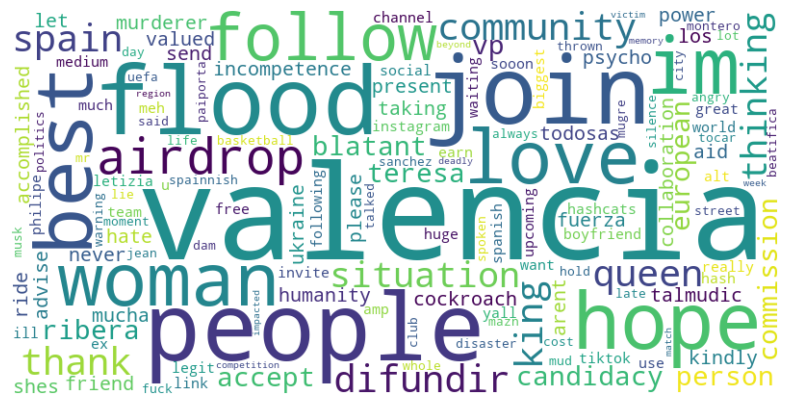

In [ ]:
# Analyse words extracted
all_words = " ".join(tweetData100.Text)
cleaned_text = clean_text(all_words)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.show()

# Endpoint 1: Get model info

In [ ]:
response = requests.get("http://127.0.0.1:8000/model_info")
load = json.loads(response.text)
metrics_list = load["model_info"]["metrics"].strip().split('\n')

# List comprehension to extract metrics as tuples (name, value)
metrics, values = zip(*[(metric.split(': ')[0], float(metric.split(': ')[1])) for metric in metrics_list])

df = pd.DataFrame(values, index = metrics, columns = ["metrics"])
df

# Endpoint 2: Predict sentiment of extracted tweets

In [ ]:
tweets = [tweet for tweet in tweetData100.Text]

In [ ]:
# Headers for the request
headers = {
    'accept': 'application/json',
    'Content-Type': 'application/json'
}

# Send the POST request
response = requests.post('http://127.0.0.1:8000/predict', headers=headers, 
                         json = {
    "text": tweets
})

# Print the response from the server
answer = response.json() 
df = pd.DataFrame(tweets, answer.values(), columns = ["tweet"])

{'I hope the @PPEuropean will not accept the candidacy of Teresa Ribera as European commission VP, a person of such blatant incompetence. #EU #ValenciaIndignada #Valencia': 'Negative', 'MUCHA FUERZA A TODOS/AS LOS #Valencianos \n"I\'m taking a ride with my best friend\nI hope he never lets me down again"\n#DanaValencia #ValenciaEstamosContigo #ValenciaIndignada #ValenciaBajoAgua #DEPECHEMODE  \nhttps://t.co/ydGZSSFcEH': 'Positive', 'This is the power of a people! 💪🏻\nWhat can be accomplished when collaboration is valued above all else. \n\n#ValenciaIndignada https://t.co/vMYNXvBp0U': 'Positive', 'Talmudic psycho cockroaches 🪳 hate humanity that aren’t them. Did you Ukraine also send some Aid for Valencia ? #ValenciaIndignada #ValenciaEspaña #ValenciaEstamosContigo #Valencia https://t.co/EYHkxZMVA1': 'Negative', '#ValenciaIndignada\n\n@salomepradas @carlos_mazon_  @NunezFeijoo \n\nMurderers!!! #DanaValencia #MazonDimisión #MazonDimissió \n\nhttps://t.co/PU3wgiZivO https://t.co/CWZVlKt8L

In [179]:
index = [3,4,5]

for i in index:
    print("SENTIMENT=", df.iloc[i].name)
    print(df.iloc[i,0])
    print("----")

SENTIMENT= Negative
Talmudic psycho cockroaches 🪳 hate humanity that aren’t them. Did you Ukraine also send some Aid for Valencia ? #ValenciaIndignada #ValenciaEspaña #ValenciaEstamosContigo #Valencia https://t.co/EYHkxZMVA1
----
SENTIMENT= Negative
#ValenciaIndignada

@salomepradas @carlos_mazon_  @NunezFeijoo 

Murderers!!! #DanaValencia #MazonDimisión #MazonDimissió 

https://t.co/PU3wgiZivO https://t.co/CWZVlKt8LC
----
SENTIMENT= Positive
Please kindly advise her … She’s in love with both present boyfriend and her Ex. What do women really wants.. 

Follow us on: 

TikTok: @lovetherapyclinic
Instagram: @lovetherapysaga 

#Election2024 #KamalaHarris #women #relationships #Trump2024 #JHOPE #ValenciaIndignada https://t.co/4hpalL2EcK
----


# Endpoint 3: Examples of positive and negative tweets

In [ ]:
# Get a sentence
response = requests.get("http://127.0.0.1:8000/random_example")
load = json.loads(response.text)

print("Positive example:")
print(load["positive_example"])

print("Negative example:")
print(load["negative_example"])